In [5]:
import pandas as pd
import os

import sys
sys.path.append("..")
from src.Eval import aggregated_results_llm, results_to_dataframe, silent_eval_llm, get_iobs_from_data, parse_filename
from src.Utils import parse_pred_file, parse_preds, read_jsonlines, read_IOB_file

results_postcut = aggregated_results_llm("../output/reddit+shsyt_cloze/postcutoff_")
results_seen = aggregated_results_llm("../output/reddit+shsyt_cloze/fmtcorrect_")
results_unseen = aggregated_results_llm("../output/reddit+shsyt_cloze/fmtfailed_")


../output/reddit+shsyt_cloze/postcutoff_/gpt-4o-mini/dataset1_35shot_tfidf.jsonl


2024-09-15 19:06:20 root INFO: Imported 533 predictions for 533 true examples


../output/reddit+shsyt_cloze/postcutoff_/gpt-4o-mini/dataset2_35shot_tfidf.jsonl


2024-09-15 19:06:21 root INFO: Imported 534 predictions for 534 true examples


../output/reddit+shsyt_cloze/fmtcorrect_/gpt-4o-mini/dataset1_35shot_tfidf.jsonl


2024-09-15 19:06:21 root INFO: Imported 533 predictions for 533 true examples


../output/reddit+shsyt_cloze/fmtcorrect_/gpt-4o-mini/dataset2_35shot_tfidf.jsonl


2024-09-15 19:06:22 root INFO: Imported 534 predictions for 534 true examples


../output/reddit+shsyt_cloze/fmtfailed_/gpt-4o-mini/dataset1_35shot_tfidf.jsonl


2024-09-15 19:06:23 root INFO: Imported 533 predictions for 533 true examples


../output/reddit+shsyt_cloze/fmtfailed_/gpt-4o-mini/dataset2_35shot_tfidf.jsonl


2024-09-15 19:06:24 root INFO: Imported 534 predictions for 534 true examples


In [6]:
results_to_dataframe(results_seen)


Value                                         \
Schema                     strict                                          
Entity Type               overall                                          
Metric                   f1_macro  f1_micro precision_macro recall_macro   
Model       Sampling k                                                     
gpt-4o-mini tfidf    35  0.878696  0.877109        0.880208     0.877758   

                                                                       \
Schema                                                                  
Entity Type                Artist                                       
Metric                         f1 precision    recall missed spurious   
Model       Sampling k                                                  
gpt-4o-mini tfidf    35  0.863151   0.88047  0.846501   51.5     27.5   

                                   ...                                     \
Schema                             ... ent_type                             
Entity Type                        ...   Artist                             
Metric                  incorrect  ...   recall missed spurious incorrect   
Model       Sampling k             ...                                      
gpt-4o-mini tfidf    35      44.5  ...  0.90641   51.5     27.5       7.0   

                                                                       \
Schema                                                                  
Entity Type                   WoA                                       
Metric                         f1 precision    recall missed spurious   
Model       Sampling k                                                  
gpt-4o-mini tfidf    35  0.942311  0.927242  0.957886   16.5     32.5   

                                   
Schema                             
Entity Type                        
Metric                  incorrect  
Model       Sampling k             
gpt-4o-mini tfidf    35       4.0  

[1 rows x 48 columns]

# Analysis

### Parse preds

In [7]:
model = "gpt-4o-mini"
k = 35
sampling = "tfidf"
data_path = f"../data/dataset/reddit+shsyt_cloze/{model}"
output_path = f"../output/reddit+shsyt_cloze"
outputs = os.listdir(data_path)

results = {}

for dirname in outputs:
    group, perturbation = dirname.split("_")

    if not results.get(perturbation):
        results[perturbation] = {}

    _path = os.path.join(data_path, dirname)

    titles = []
    performers = []
    texts = []
    tags = []
    pred_tags = []

    for dataset in os.listdir(_path):
        _texts, _tags = read_IOB_file(os.path.join(_path, dataset, "test.IOB"))
        texts += _texts
        tags += _tags

        __path = os.path.join(output_path, dirname, model)
        for pred_file in [f for f in os.listdir(__path) if dataset in f]:
            _, pred_k, pred_sampling = parse_filename(pred_file)
            if pred_k == k and pred_sampling == sampling:
                pred_path = os.path.join(__path, pred_file)
                pred_data = read_jsonlines(pred_path)
                true_iobs, pred_iobs = get_iobs_from_data(pred_data)
                pred_tags += pred_iobs
   
        titles += [d.get("titles") for d in pred_data]
        performers += [d.get("performers") for d in pred_data]

    results[perturbation]['_'.join((group, "titles"))] = titles
    results[perturbation]['_'.join((group, "performers"))] = performers
    results[perturbation]['_'.join((group, "TEXT"))] = [list(a) for a in texts]
    results[perturbation]['_'.join((group, "IOB"))] = [list(a) for a in tags]
    results[perturbation]['_'.join((group, "IOB-pred" ))] = pred_tags

_data1 = pd.read_parquet("../data/dataset/reddit+shsyt_cloze/data_template.parquet").reset_index()
_data1.columns = pd.MultiIndex.from_tuples([('', '', col) for col in _data1.columns])

_data2 = pd.DataFrame.from_dict({(i, j): results[i][j] 
                             for i in results.keys() 
                             for j in results[i].keys()},
                            orient='index').T
_data2.columns = pd.MultiIndex.from_tuples([(t[0], t[1].split("_")[0], t[1].split("_")[1]) for t in _data2.columns], 
                                      names=['Perturbation', 'Group', 'Value'])

data = pd.concat([_data1, _data2], axis=1)


In [9]:
import importlib.util
import sys
from pathlib import Path
file_path = Path("../baseline/music-ner-eacl2023/music-ner/src/ner_eval.py").resolve()
spec = importlib.util.spec_from_file_location("ner_eval", str(file_path))
ner_eval = importlib.util.module_from_spec(spec)
from ner_eval import Evaluator

eval_scheme = "strict"

def eval_pair(true_iobs, pred_iobs):
    if len(true_iobs) == len(pred_iobs):
        evaluator = Evaluator([true_iobs], [pred_iobs], ["Artist", "WoA"])
        result = evaluator.evaluate()
        overall, by_cls = result[0]["strict"], result[1]
        return overall, by_cls
    return None

for perturbation in data.columns.get_level_values(0).unique():
    for group in data.columns.get_level_values(1).unique():
        if group != '':
            series = data.apply(lambda row: eval_pair(
                    row[(perturbation, group, "IOB")], row[(perturbation, group, "IOB-pred")]), axis=1)
            data[(perturbation, group, "metrics_overall")] = series.apply(lambda x: x[0] if x else None)
            for cls in ["Artist", "WoA"]:
                for outcome in ["incorrect", "missed", "spurious"]:
                    data[(perturbation, group, f"{cls}_{outcome}")] = series.apply(lambda x: x[1][cls][eval_scheme][outcome] if x else None)


2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Imported 1 predictions for 1 true examples
2024-09-15 19:08:50 root INFO: Importe

## Robust Contexts

In [11]:
col = ('','fmtcorrect', 'WoA_incorrect')

def mask_has_metric(data, col):
    return data[col] > 0

e=data.loc[mask_has_metric(data, col), [('','fmtcorrect', "TEXT"), ('','fmtcorrect', "IOB"), 
                                        ('','fmtcorrect', "IOB-pred")]].iloc[0]
e

  fmtcorrect  TEXT        [i, aint, no, miracle, worker, music, clip, -,...
              IOB         [B-WoA, I-WoA, I-WoA, I-WoA, I-WoA, O, O, O, B...
              IOB-pred           [O, O, O, B-WoA, I-WoA, O, O, O, B-Artist]
Name: 17, dtype: object

# Performance per Group: 
### Bar Plot: x-Axis: Seen, Unseen, Post-Cutoff, y-Axis: Incorrect, Spurious, Missed


/tmp/ipykernel_3152272/1987779439.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  plot_data = plot_data.stack(level=0).reset_index(
2024-09-15 19:12:51 matplotlib.pyplot DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-09-15 19:12:51 matplotlib.pyplot DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-09-15 19:12:51 matplotlib.font_manager DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-09-15 19:12:51 matplotlib.font_manager DEBUG: findfont: score(FontEntry(fname='/data/miniconda3/envs/torch21/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700

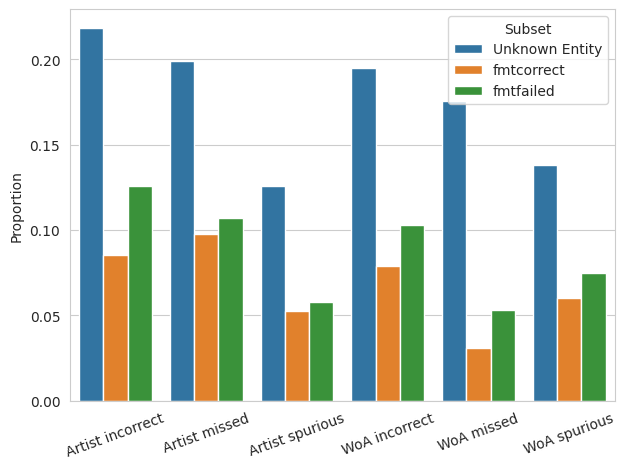

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['WoA_spurious', 'WoA_incorrect', 'WoA_missed', 'Artist_spurious', 'Artist_incorrect', 'Artist_missed']

plot_data = data[""]
plot_data = plot_data.loc[:, plot_data.columns.get_level_values(1).isin(metrics)]

plot_data = plot_data.stack(level=0).reset_index(
    level=0, drop=True).reset_index().groupby(by="index").sum().reset_index().rename(
        columns={"index": "Subset"}
    )
plot_data.Subset = plot_data.Subset.str.replace(
    "unseen", "FMT Incorrect").str.replace(
        "seen", "FMT Correct").str.replace("postcutoff", "Unknown Entity")

plot_data = pd.melt(plot_data, 
                    id_vars="Subset", 
                    value_vars=metrics, 
                    var_name="Metric", 
                    value_name="Proportion").sort_values(by=["Subset", "Metric"])
plot_data.Metric = plot_data.Metric.str.replace("_", " ")
plot_data.Proportion = plot_data.Proportion / len(data)

sns.set_style("whitegrid")
sns.barplot(data=plot_data, x='Metric', y="Proportion", hue='Subset')
plt.xlabel("")
plt.xticks(rotation=20)
plt.title("")
plt.legend(title="Subset")
plt.tight_layout()
plt.savefig(f"../figures/error_analysis.pdf")
plt.show()



# Further questions
- exact eval scheme vs. strict
- context length per Origin (YouTube Reddit Context)
    - scatter plot
    - Correlation
- contexts
    - robust (no mistakes in neither of the groups)
    - 


In [18]:
mask_robust = data.loc[:,data.columns.get_level_values(1).isin(metrics)].T.sum() == 0

data[mask_robust].sample(1)


\
                                           
    index            id   set_id  Origin   
418   456  dataset1_433  10449.0  Reddit   

                                                        \
                                                         
                                                  TEXT   
418  [intense, songs, like, ", the, chain, ", by, f...   

                                                                             \
                                                                              
                                                   IOB subset yt_id has_WoA   
418  [O, O, O, O, B-WoA, I-WoA, O, O, B-Artist, I-A...      4   433    True   

                ...      perturb2                          \
                ...     fmtfailed                           
    has_Artist  ... WoA_incorrect WoA_missed WoA_spurious   
418       True  ...           0.0        0.0          0.0   

                                                                         \
                                            fmtcorrect                    
                                       metrics_overall Artist_incorrect   
418  {'correct': 2, 'incorrect': 0, 'partial': 0, '...              0.0   

                                                                         
                                                                         
    Artist_missed Artist_spurious WoA_incorrect WoA_missed WoA_spurious  
418           0.0             0.0           0.0        0.0          0.0  

[1 rows x 122 columns]

2024-09-15 19:27:28 matplotlib.colorbar DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fa57ed23910>


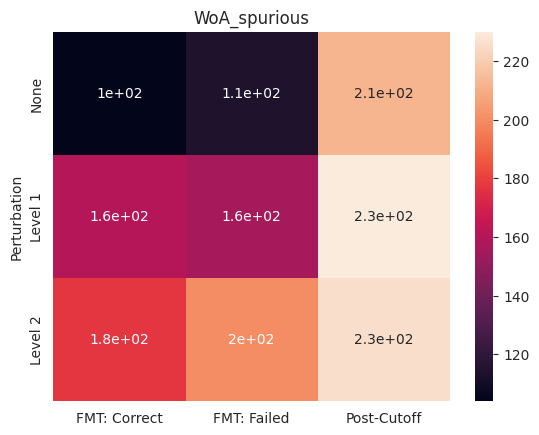

2024-09-15 19:27:28 matplotlib.colorbar DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fa57ecce290>


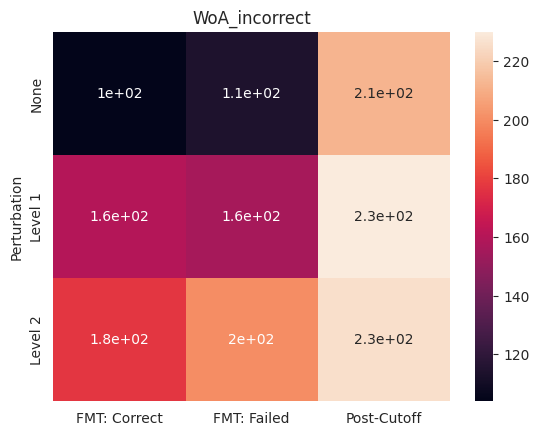

2024-09-15 19:27:29 matplotlib.colorbar DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fa57ee22ed0>


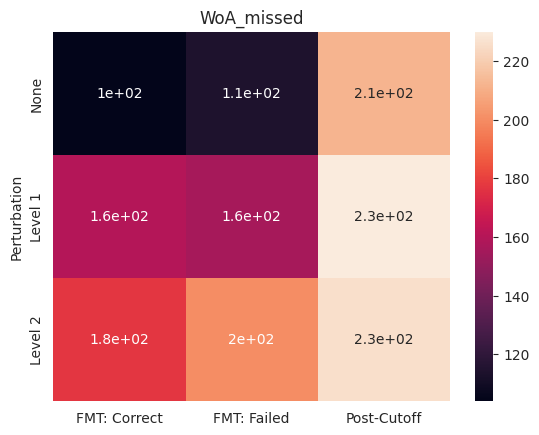

2024-09-15 19:27:29 matplotlib.colorbar DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fa57edb1a90>


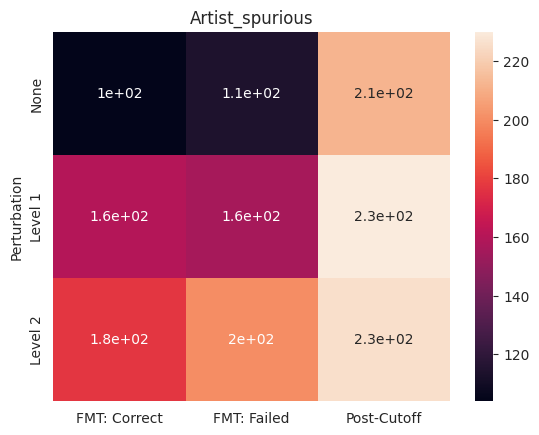

2024-09-15 19:27:29 matplotlib.colorbar DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fa57ef15850>


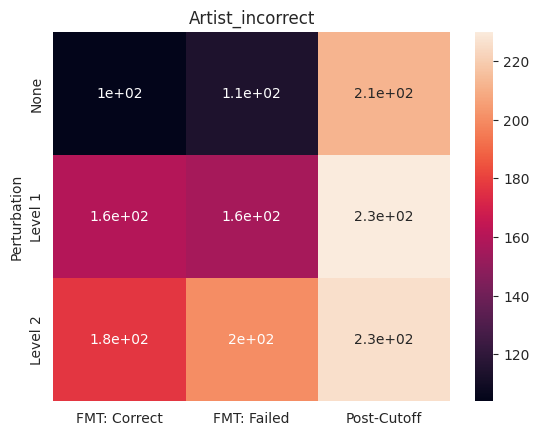

2024-09-15 19:27:29 matplotlib.colorbar DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fa57efdf3d0>


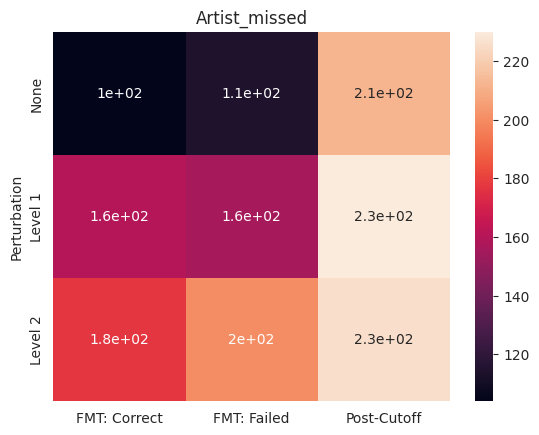

In [50]:
def get_metric_sums(df, metric):
    metric_df = df.xs(metric, axis=1, level=2)
    metric_sum = metric_df.sum()
    metric_sum_df = metric_sum.unstack(level=1)
    return metric_sum_df


for metric in metrics:

    plot_data = get_metric_sums(data, "Artist_missed")
    plot_data = plot_data[["fmtcorrect", "fmtfailed", "postcutoff"]]
    plot_data.columns = ["FMT: Correct", "FMT: Failed", "Post-Cutoff"]
    plot_data.index = [["None", "Level 1", "Level 2"]]
    sns.heatmap(plot_data, annot=True)
    plt.title(metric)
    plt.ylabel("Perturbation")
    plt.show()



In [25]:
def get_mask_for_metric(metric: str):
    return data.loc[:,data.columns.get_level_values(1).str.contains(metric)].T.sum() == 3

def get_unrobust_cloze_texts(data: pd.DataFrame, metric: str, nsample: int):
    data = data[get_mask_for_metric(metric)].sample(frac=1)
    texts = data[("", "TEXT_template")].apply(lambda x: ' '.join(x)).to_list()
    origins = data[("", "Origin")].to_list()
    return texts[:nsample], origins[:nsample]

get_unrobust_cloze_texts(data, "WoA_spurious", 10)


([], [])

In [19]:
get_unrobust_cloze_texts(data, "WoA_missed", 10)


NameError: name 'get_unrobust_cloze_texts' is not defined

In [16]:
get_unrobust_cloze_texts(data, "WoA_incorrect", 10)


(['8 - [WoA] [Artist] - [WoA] [Artist]',
  '[Artist] - [WoA] ( [WoA] / [WoA] )',
  'music like " [WoA] " from [WoA]',
  '13 [WoA] ( [WoA] ) by [Artist]',
  'songs / bands like the metalcore [WoA] from [WoA] : waw zombies ?',
  'these songs are not that well known but what are some american artists or songs that are similar to [Artist] - [WoA] , [Artist] - [WoA] , [Artist] - [WoA] ?',
  'more like the [WoA] theme song by [Artist] ! energetic jazz ?',
  '[Artist] - [WoA] blues',
  '[Artist] - [WoA] part 1 & 2',
  'music like [Artist] [WoA] and [Artist] [WoA]'],
 ['YouTube',
  'YouTube',
  'Reddit',
  'YouTube',
  'Reddit',
  'Reddit',
  'Reddit',
  'YouTube',
  'YouTube',
  'Reddit'])

In [17]:
get_unrobust_cloze_texts(data, "Artist_missed", 10)


(['[Artist] [Artist] [WoA] ( film : das lied ist aus )',
  'looking for bands like [Artist] , [Artist] , [Artist] , [Artist] , [Artist]',
  '[WoA] - [Artist] [Artist]',
  'any similar songs like " [WoA] by [Artist] " or " [WoA] also by [Artist] " or " [WoA] [Artist] " rock songs with clean vocals ?',
  'what should my wife listen to if she likes [Artist] , [Artist] , [Artist] and [Artist] ?',
  '[Artist] ( [Artist] ) - [WoA]',
  '[WoA] - [Artist] , [Artist] , [Artist] , & [Artist] - [WoA]',
  '[Artist] & [Artist] - [WoA] ( live )',
  'the hit man & her may [YEAR] - [Artist] with [Artist] on keyboards ! ha ! - [WoA] !',
  '[WoA] - vintage [Artist] style [Artist] cover ft . [Artist]'],
 ['YouTube',
  'Reddit',
  'YouTube',
  'Reddit',
  'Reddit',
  'YouTube',
  'YouTube',
  'YouTube',
  'YouTube',
  'YouTube'])

In [18]:
get_unrobust_cloze_texts(data, "Artist_incorrect", 10)


(['[WoA] - [Artist] ( [Artist] , [Artist] , [Artist] )',
  '[Artist] - theme from [WoA] ( by earpjohn )',
  'looking for music similar to [WoA] - [Artist] and [WoA] - [Artist]',
  'trying to find the music genre and any suggestions like the second half of this song ( already set the start point to halfway ) similar to [Artist] [WoA] / the dream',
  'lokking for alternative metal like [Artist] and [Artist] with eerie sounding melody',
  'similar to [WoA] ( remix ) by [Artist] or [WoA] / [WoA] = genius / [WoA] - [Artist] , or [WoA] - [Artist] / [Artist]',
  '[Artist] [Artist] [Artist] - [WoA] ( with lyrics )',
  '[Artist] - - - [WoA] - ( cover - by [Artist] bailey ) - official - cover - music - video',
  'i really enjoy laid back rap that has witty lyrics and a good beat , like [WoA] - [Artist] or [WoA] - [Artist] . looking for more suggestions like these',
  'songs similar to [WoA] ( [Artist] remix ) , [WoA] ( [Artist] ) , [WoA] ( [Artist] ) , [WoA] ( [Artist] )'],
 ['YouTube',
  'YouTu

In [27]:
get_unrobust_cloze_texts(data, "Artist_spurious", 10000)


(['beat / song like [WoA] by [Artist] , the creator ?',
  '[Artist] - [WoA] ( official music video )',
  '[Artist] - theme from [WoA] ( by earpjohn )',
  '[WoA] [Artist] [YEAR] sanat jaana rinne',
  'the hit man & her may [YEAR] - [Artist] with [Artist] on keyboards ! ha ! - [WoA] !',
  '[WoA] - - laura ault',
  '[Artist] [Artist] [WoA] ( film : das lied ist aus )',
  'misfits - [WoA] fiend lounge',
  '[Artist] big surprise | oprahs lifeclass | oprah winfrey network',
  '[Artist] " [WoA] " cover with male vocalist',
  '[Artist] - [WoA] ( nino rota )',
  '[Artist] - [WoA] ( aqua - [WoA] parody ) (',
  'GuanShuYi - [WoA] ( hq )',
  'ive been getting into [Artist] and [Artist] recently . also looking for artists similar to [Artist] [Artist] and that kinda vibe',
  'pinocho - [WoA]',
  '[ pvhuru ] banirabinzu「kids」（mgmt cover） - [Artist]',
  '[WoA] - gilda ( [YEAR] )',
  'dark indie artists / playlists like [Artist] , [Artist] - fang , [Artist] and [Artist] .',
  '[Artist] - [WoA] | swr bi

/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
2024-09-13 13:13:31 matplotlib.backends.backend_pdf DEBUG: Assigning font /F1 = '/data/miniconda3/envs/torch21/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


2024-09-13 13:13:31 matplotlib.backends.backend_pdf DEBUG: Embedding font /data/miniconda3/envs/torch21/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2024-09-13 13:13:31 matplotlib.backends.backend_pdf DEBUG: Writing TrueType font.


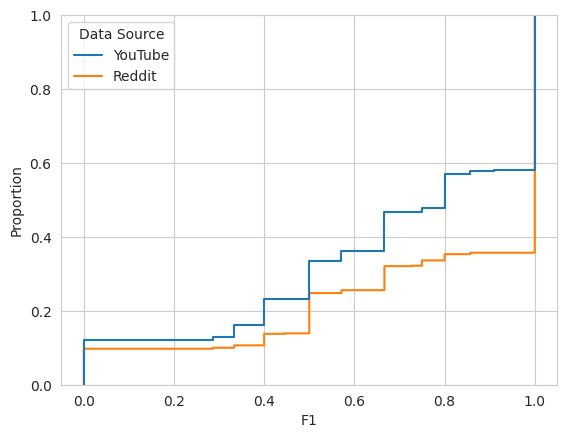

In [122]:
data[("", "f1")] = data[('unseen','metrics_overall')].apply(lambda x: x["f1"] if x else None)

sns.ecdfplot(data, x=("", "f1"), hue=("", "Origin"), legend="Data Source")
legend = plt.gca().get_legend()
legend.set_title("Data Source")
plt.xlabel("F1")
plt.savefig("../figures/f1_distributions.pdf")
plt.show()


In [63]:
data.sort_values(by=("", "nerrors"), ascending=False)[
    [("", "TEXT_template"), ("", "Origin"), ("", "nO_tags")]].loc[1:30]


TEXT_template   Origin nO_tags
1                                    [[WoA], -, [WoA]]  YouTube       1
546   [melancholia, ,, doom, -, music, like, [Artist]]   Reddit       6
216  [[WoA], -, [Artist], (, 8, inch, edison, bell, )]  YouTube       7
219             [[Artist], -, [WoA], (, nino, rota, )]  YouTube       5
245           [[Artist], 1, /, 10, (, original, lp, )]  YouTube       7
254  [[Artist], -, theme, from, [WoA], (, by, earpj...  YouTube       7
222  [#, 22, -, [WoA], -, -, a, cappella, by, [Arti...  YouTube       8
224                               [[WoA], (, [WoA], )]  YouTube       2
708  [more, classical, like, this, ;, [Artist], -, ...   Reddit      11
523  [what, songs, are, similar, to, [WoA], and, [W...   Reddit       8
649  [[Artist], ., live, [WoA], ., cant, get, enoug...   Reddit      17
626  [polish, -, canadian, folk, rock, -, [Artist], .]   Reddit       7
480      [songs, like, [WoA], (, or, pyl', glotaiu, )]   Reddit       7
573  [suggest, me, more, artist, like, [Artist], an...   Reddit       6
494  [looking, for, songs, similar, to, the, first,...   Reddit      11
577            [more, songs, like, [Artist], -, [WoA]]   Reddit       4
316  [request, :, songs, like, [Artist], [WoA], ;, ...   Reddit      10
583  [music, like, [Artist], ,, [Artist], ,, [Artis...   Reddit       7
692  [instramental, music, similar, to, [WoA], by, ...   Reddit       5
554                        [what, genre, is, [WoA], ?]   Reddit       4
265            [[Artist], -, [WoA], |, swr, big, band]  YouTube       5
285  [i, love, [Artist], [WoA], ., something, simil...   Reddit      12
585  [instrumental, piano, music, similar, to, [Art...   Reddit       9
586  [looking, for, a, band, like, [Artist], ,, [Ar...   Reddit      14
658       [something, like, the, [WoA], soundtrack, ?]   Reddit       5
591  [english, alternative, rock, /, electro, songs...   Reddit      13
534  [songs, like, [Artist], ., kellys, [WoA], :, l...   Reddit      18
489  [similar, artists, to, [Artist], (, other, tha...   Reddit       8
617  [songs, like, this, ?, [WoA], :, how, does, it...   Reddit      17
256                          [[WoA], -, the, [Artist]]  YouTube       2
260                              [[WoA], lyric, video]  YouTube       2
525              [[Artist], -, [WoA], ft, ., [Artist]]   Reddit       3
810  [any, suggestions, for, songs, like, this, ?, ...   Reddit      41
880  [any, song, suggestions, for, something, that,...   Reddit       9
113                                 [[WoA], 02, [WoA]]  YouTube       1
948                                     [[WoA], remix]   Reddit       1
944  [songs, similar, to, [Artist], -, [WoA], (, ft...   Reddit      13
70   [[Artist], -, -, -, [WoA], -, (, cover, -, by,...  YouTube      18
73   [[WoA], /, [WoA], (, part, 1, ), (, from, “int...  YouTube      14
930       [some, tunes, with, [Artist], like, guitars]   Reddit       5
929  [songs, like, [WoA], by, [Artist], in, terms, ...   Reddit       9
925  [suggestions, for, song, inspirations, on, the...   Reddit       8
916  [looking, for, music, similar, to, [Artist], :...   Reddit       7
413  [looking, for, similar, sad, ,, depressed, ,, ...   Reddit      20
86                                      [01, -, [WoA]]  YouTube       2
415  [in, need, of, some, music, similar, to, the, ...   Reddit      13
901  [any, similar, songs, like, ", [WoA], by, [Art...   Reddit      21
101                     [[Artist], &, [Artist], [WoA]]  YouTube       1
881  [songs, thematically, similar, to, [WoA], ., b...   Reddit       6
475              [similar, music, to, [Artist], [WoA]]   Reddit       3
879  [if, i, like, [Artist], feat, ., [Artist], !, ...   Reddit      13
358                            [[Artist], -, all, day]   Reddit       3
962     [[Artist], -, [WoA], ?, (, ft, ., [Artist], )]   Reddit       6
54                                    [[WoA], ., ., .]  YouTube       3
963  [old, school, rock, /, pop, like, [Artist], -,...   Reddit      11
30   [[Wo

In [38]:
data[("", "nerrors")].max()

20.0

\
     index                id   set_id   Origin   
2      170    58_hQz-aZH-ozU     58.0  YouTube   
8      615   214_SmbRP5LUKJs    214.0  YouTube   
19    2131  2156_qvq1cEVSdLA   2156.0  YouTube   
25    2922  7072_Xo4KJ2Qa7Kg   7072.0  YouTube   
27    3107  8150_lalAL8KpmBI   8150.0  YouTube   
...    ...               ...      ...      ...   
1050  2654      dataset4_726  12647.0   Reddit   
1051  2658      dataset4_730  12651.0   Reddit   
1052  2659      dataset4_731  12652.0   Reddit   
1054  2672      dataset4_743  12665.0   Reddit   
1057  2680      dataset4_750  12673.0   Reddit   

                                                         \
                                                   TEXT   
2                  [juan, rozoff, -, plaisir, d, amour]   
8     [«enjoy, the, silence», by, «smashing, potatoes»]   
19    [purple, rain, -, phish, -, lincoln, ,, ne, 10...   
25    [say, yes, !, a, tribute, to, elliott, smith, ...   
27    [caecilie, norby, -, rules, of, the, road, ., ...   
...                                                 ...   
1050  [looking, for, songs, that, give, the, same, v...   
1051             [songs, like, vincent, or, imagine, ?]   
1052                    [ghostin, -, ariana, grande, ?]   
1054                  [gently, wind, |, joshua, speedy]   
1057  [looking, for, an, album, or, ep, in, cassette...   

                                                                             \
                                                    IOB subset        yt_id   
2          [B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]      1  hQz-aZH-ozU   
8          [B-WoA, I-WoA, I-WoA, O, B-Artist, I-Artist]      2  SmbRP5LUKJs   
19    [B-WoA, I-WoA, O, B-Artist, O, O, O, O, O, O, ...      4  qvq1cEVSdLA   
25    [B-WoA, I-WoA, I-WoA, O, O, O, B-Artist, I-Art...      5  Xo4KJ2Qa7Kg   
27    [B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA, I...      1  lalAL8KpmBI   
...                                                 ...    ...          ...   
1050  [O, O, O, O, O, O, O, O, O, O, O, O, B-Artist,...      3          726   
1051                         [O, O, B-WoA, O, B-WoA, O]      2          730   
1052                  [B-WoA, O, B-Artist, I-Artist, O]      3          731   
1054              [B-WoA, I-WoA, O, B-Artist, I-Artist]      1          743   
1057  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...      4          750   

                         ... postcutoff               \
     has_WoA has_Artist  ... WoA_missed WoA_spurious   
2       True       True  ...        0.0          0.0   
8       True       True  ...        0.0          0.0   
19      True       True  ...        0.0          0.0   
25      True       True  ...        0.0          0.0   
27      True       True  ...        0.0          0.0   
...      ...        ...  ...        ...          ...   
1050    True       True  ...        0.0          0.0   
1051    True      False  ...        0.0          0.0   
1052    True       True  ...        0.0          0.0   
1054    True       True  ...        0.0          0.0   
1057   False       True  ...        0.0          0.0   

                                                 unseen                   \
                                        metrics_overall Artist_incorrect   
2     {'correct': 2, 'incorrect': 0, 'partial': 0, '...              0.0   
8     {'correct': 2, 'incorrect': 0, 'partial': 0, '...              0.0   
19    {'correct': 2, 'incorrect': 0, 'partial': 0, '...              0.0   
25    {'correct': 2, 'incorrect': 0, 'partial': 0, '...              0.0   
27    {'correct': 2, 'incorrect': 0, 'partial': 0, '...              0.0   
...                                                 ...              ...   
1050  {'correct': 2, 'incorrect': 0, 'partial': 0, '...              0.0   
1051  {'correct': 2, 'incorrect': 0, 'partial': 0, '...              0.0   
1052  {'correct': 2, 'incorrect': 0, 'partial': 0, '...              0.0   
1054  {'correct': 2, 'incorrect': 0,

In [32]:
nerrors

0        5.0
1        4.0
2        0.0
3        2.0
4       11.0
        ... 
1053     1.0
1054     0.0
1055     4.0
1056     1.0
1057     0.0
Length: 1058, dtype: float64

/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


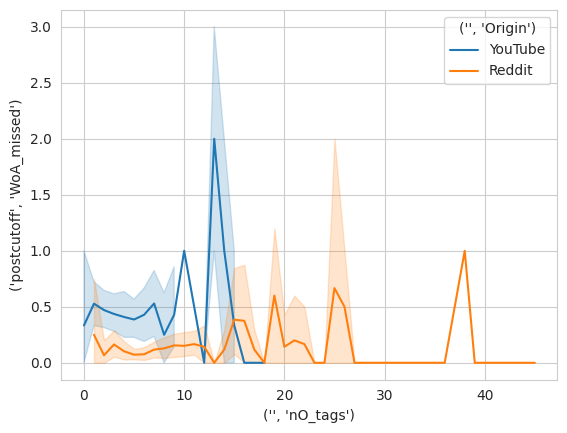

In [10]:
xcol = ("", "nO_tags")
ycol = ("postcutoff", "WoA_spurious")
huecol = ("", "Origin")

sns.lineplot(data=data, x=("", "nO_tags"), y=("postcutoff", "WoA_missed"), hue=("", "Origin"))
plt.show()


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


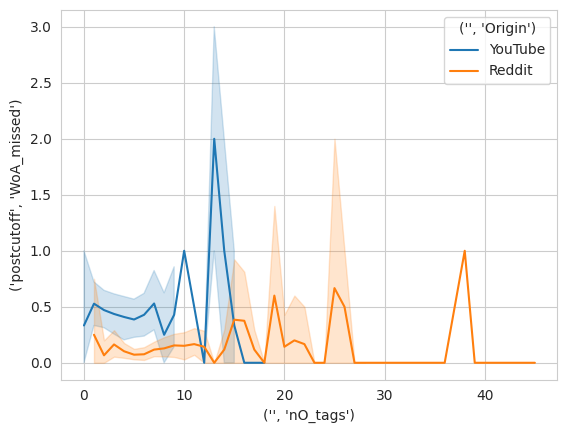

In [11]:
xcol = ("", "nO_tags")
ycol = ("postcutoff", "WoA_incorrect")
huecol = ("", "Origin")

sns.lineplot(data=data, x=("", "nO_tags"), y=("postcutoff", "WoA_missed"), hue=("", "Origin"))
plt.show()


# Clusters

2024-09-13 11:28:41 matplotlib.colorbar DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f6b34463210>


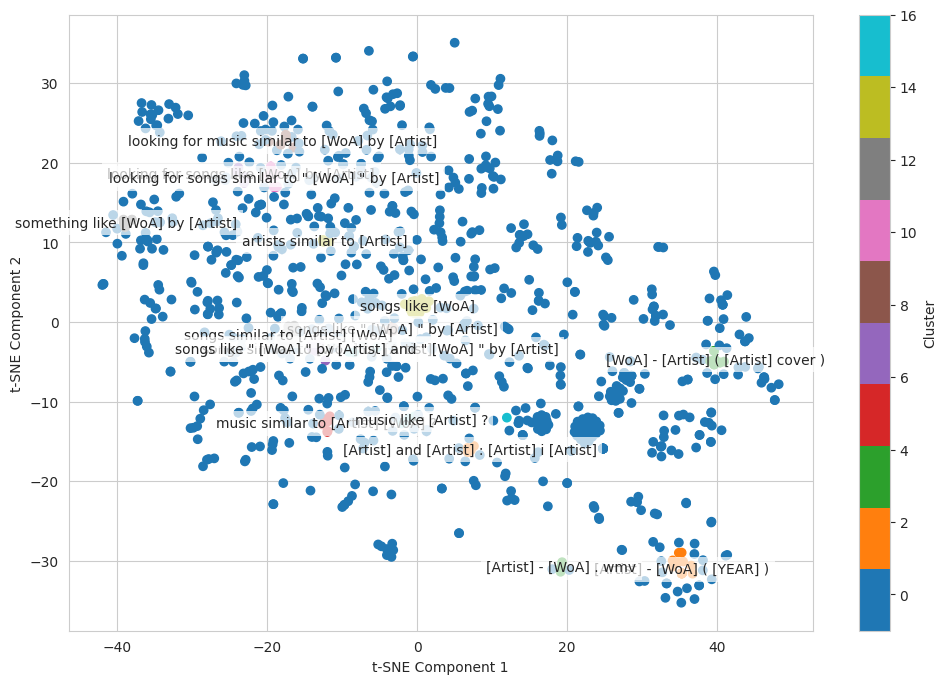

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import numpy as np


# Convert text data into TF-IDF vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data[("", 'TEXT_template')].apply(lambda x: ' '.join(x)))

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X)

# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X.toarray())

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='tab10', marker='o')  # Use a visible color map

# Count samples per cluster
unique_clusters, counts = np.unique(clusters, return_counts=True)
cluster_counts = dict(zip(unique_clusters, counts))

# Annotate clusters with sample texts
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1 or cluster_id == 0:
        # Skip noise points (cluster_id == -1)
        continue
    if count > 1:  # Example threshold; adjust as needed
        cluster_indices = np.where(clusters == cluster_id)[0]
        # Use the first sample in the cluster for labeling
        sample_text = ' '.join(data[("", 'TEXT_template')].iloc[cluster_indices[0]])
        # Compute centroid
        cluster_points = X_tsne[cluster_indices]
        centroid = cluster_points.mean(axis=0)
        plt.text(centroid[0], centroid[1], sample_text, fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add a color bar and labels
plt.colorbar(scatter, label='Cluster')
#plt.title('DBSCAN Clusters in 2D Space (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig("Cloze Text Clustered")
plt.show()



In [13]:

X

<1058x1046 sparse matrix of type '<class 'numpy.float64'>'
	with 7185 stored elements in Compressed Sparse Row format>